In [15]:
import torch, random, os, multiprocessing
import numpy as np, pandas as pd
import torch.nn as nn
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import torchio as tio
# multiprocess cpu 
from sklearn.metrics import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from torch.utils.data import TensorDataset, DataLoader
from tqdm import tqdm
num_workers = multiprocessing.cpu_count()
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cudnn.benchmark = True
random.seed(1234)
torch.manual_seed(1234)
csv_path = '../csv/NIHSS_Continuous_Variable_222patient.csv'
table_ =  pd.read_csv(csv_path, index_col=False)
table_label = table_.drop(['ID','rnn_sum(out-in)'] ,axis=1)                           
print("table_label.columns.values", len(table_label.columns.values))
# table_label.to_csv('./NIHSS_fiter_222patient.csv',index=False)
scaler = MinMaxScaler(feature_range=(-1, 1))
scaler = scaler.fit(table_label)

y_nor = scaler.transform(table_label)
# print(y_nor)
# new_table_nor = pd.DataFrame(y_nor, columns=table_label.columns)
new_table_nor = table_label

X_table = new_table_nor.drop(['out_sum'] ,axis=1)
y_table = new_table_nor['out_sum']

X_train, X_test, y_train, y_test = train_test_split(np.array(X_table), np.array(y_table), test_size=0.25, random_state=123) #seed = 42, 123
print("train", y_train.shape, "test", y_test.shape)
training_set = TensorDataset(torch.FloatTensor(X_train), torch.FloatTensor(y_train))
validation_set = TensorDataset(torch.FloatTensor(X_test), torch.FloatTensor(y_test))



table_label.columns.values 23
train (166,) test (56,)


In [16]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.layer = torch.nn.Linear(22, 1)

    def forward(self, x):
        x = self.layer(x)      
        return x
    def initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                torch.nn.init.normal_(m.weight.data, 0, 0.01)
                m.bias.data.zero_()

In [17]:
def validate(valid_loader, model):
    model.eval()
    stream_v = tqdm(valid_loader)
    with torch.no_grad():
        for i, (value, count) in enumerate(stream_v, start=1):
            # print(nihss)
            output = model(value.to(device)).squeeze(-1)
            # print("Target", count.cpu().detach().numpy())
            # print("Output",output.cpu().detach().numpy())
    return count.cpu().detach().numpy(), output.cpu().detach().numpy()

In [18]:
S2_weight_stack = '../checkpoint/TEST01.10-03-222_patient_sum_ONLY_NIHSS_score_22(Continuous Variable)_NoneNorm/best - vloss - out_sum - linear regression - Adam - lr_0.003 - epoch_300- CEL.pt'
net = Net()
net.initialize_weights()
checkpoint = torch.load(S2_weight_stack, map_location=torch.device(device))
net.load_state_dict(checkpoint['model_state_dict'])
net.to(device)
train_loader = DataLoader(training_set, batch_size=8, shuffle=True, num_workers=10)
valid_loader = DataLoader(validation_set, batch_size=56, shuffle=False, num_workers=4)
ground, predict = validate(valid_loader, net)


100%|██████████| 1/1 [00:00<00:00,  3.82it/s]


In [14]:
print("MAE: ", mean_absolute_error(ground, predict))
print("MSE: ", mean_squared_error(ground, predict))
print("MAPE: ", mean_absolute_percentage_error(ground, predict))

MAE:  1.211181
MSE:  6.5641775
MAPE:  0.29461607


Text(0, 0.5, 'Score')

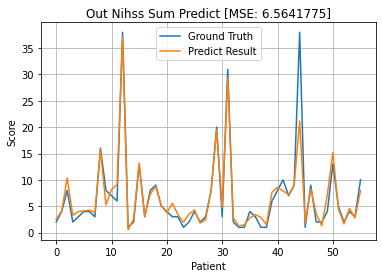

In [22]:
import matplotlib.pyplot as plt
plt.title(f"Out Nihss Sum Predict [MSE: {str(mean_squared_error(ground, predict))}]")
plt.plot(ground)
plt.plot(predict)
plt.legend(['Ground Truth', 'Predict Result']) 
plt.grid(True)
plt.xlabel("Patient")
plt.ylabel("Score")